# Understanding the signal

Understanding the signal essentially is the crux of the project. Therefore it seems like the most prudent place to start my analysis, as by having a clear understanding of the signal, it may present a trading strategy or at least point me in the right direction. 




In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from sklearn.model_selection import train_test_split

processed_file_path = "../data/processed/processed_data.csv"
data = pd.read_csv(processed_file_path)

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

print("Training Data:")
print(train_data.head())

train_data.to_csv("../data/processed/train_data.csv", index=False)
test_data.to_csv("../data/processed/test_data.csv", index=False)


Training Data:
   Unnamed: 0    signal  equity_curve  equity_returns
0           1 -0.023860      0.369910       -0.009910
1           2 -0.010445      0.366245        0.006960
2           3 -0.007646      0.368794       -0.004174
3           4 -0.000148      0.367254       -0.015721
4           5 -0.011530      0.361481       -0.006456


### Correlation Analysis & Signal distribution

First, let's examine the overall correlation between the signals and equity returns and also look at the distribution of the signals.

Overall correlation between signals and equity returns: 0.02201057612998876


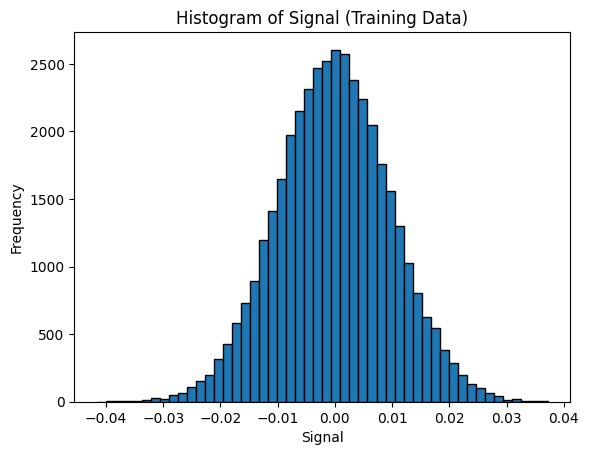

In [48]:
correlation = train_data['signal'].corr(train_data['equity_returns'])
print(f"Overall correlation between signals and equity returns: {correlation}")

plt.hist(train_data['signal'], bins=50, edgecolor='k')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.title('Histogram of Signal (Training Data)')
plt.show()

### Analyzing Returns for Positive and Negative Signals

Let's break down the equity returns for positive and negative signals to understand their distributions.

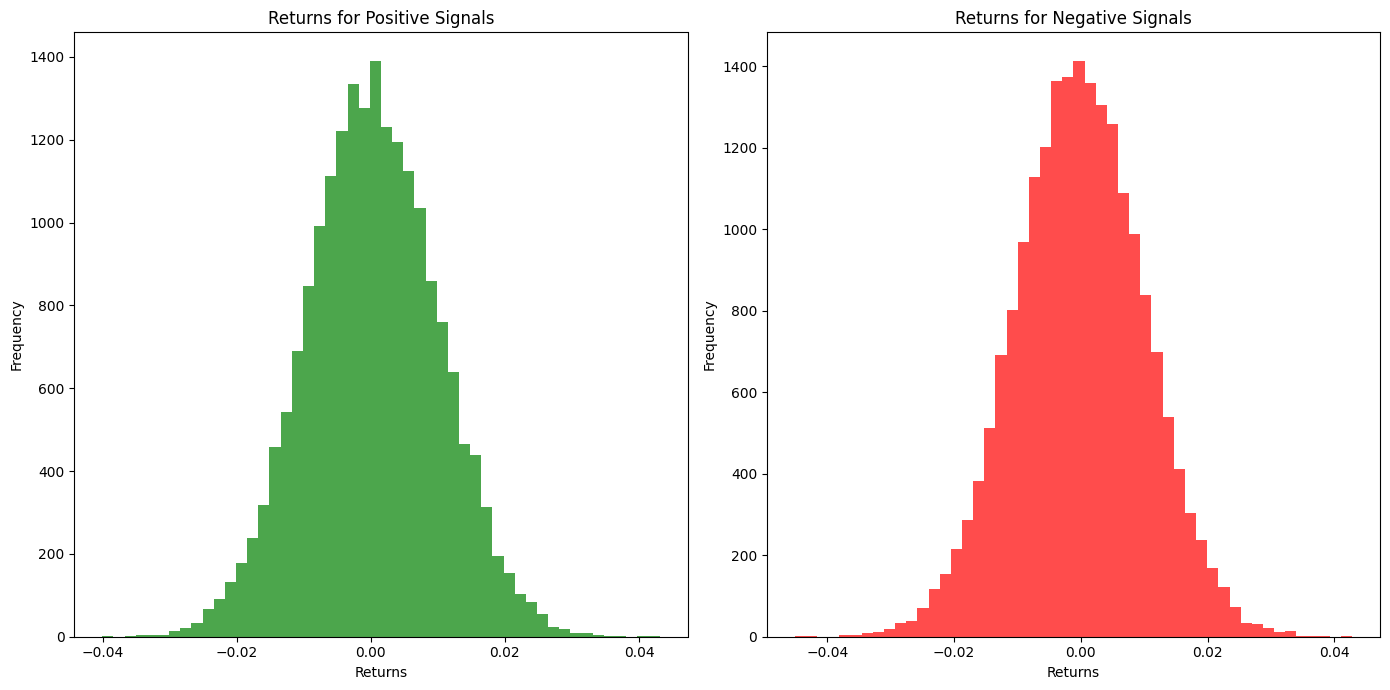

In [49]:
positive_signals = train_data[train_data['signal'] > 0]['equity_returns']
negative_signals = train_data[train_data['signal'] < 0]['equity_returns']

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(positive_signals, bins=50, color='green', alpha=0.7)
plt.title('Returns for Positive Signals')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(negative_signals, bins=50, color='red', alpha=0.7)
plt.title('Returns for Negative Signals')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Statistical Significance of Signals

Next, we'll perform t-tests to determine if the returns for positive and negative signals are statistically significant.

### Hypothesis Testing

So far, our analysis has shown the distributions of signals and returns but has not definitively confirmed the predictive power of the signals. To address this, we will test the null hypothesis that positive signals do not lead to positive returns and negative signals do not lead to negative returns.

Rejecting this null hypothesis will confirm the directionality of our signals, validating their use in predicting the directionality of future returns. This step is critical because it establishes whether the signals can reliably guide trading decisions.


In [50]:
t_stat_pos, p_val_pos = ttest_1samp(positive_signals, 0)
print(f"T-Test for Positive Signals: t-statistic = {t_stat_pos}, p-value = {p_val_pos}")

t_stat_neg, p_val_neg = ttest_1samp(negative_signals, 0)
print(f"T-Test for Negative Signals: t-statistic = {t_stat_neg}, p-value = {p_val_neg}")

T-Test for Positive Signals: t-statistic = 3.8328106625168292, p-value = 0.00012708112767844832
T-Test for Negative Signals: t-statistic = -2.2186014530113454, p-value = 0.02652487038105878


# Critical Finding

The results of the t-tests indicate that positive signals are associated with positive returns and negative signals are associated with negative returns. We can make this inference because the p-values for both tests are below the threshold of 0.05, which indicates statistical significance that we can reject the null hypothesis for both tests. This is a significant finding as it confirms that the signals are directionally meaningful along with informing us mathematically the directionality of the signals in terms of the returns they forecast.

## Signal Value Analysis

Now that we have established the directionality of the signals, it is crucial to understand the magnitude of these values. In this section, we will analyze the signal values to determine if they provide further insights into predicting future returns.

### Quartile Analysis

To understand the meaning of the signal values, we will group the signals into quartiles and examine their corresponding returns. By doing this, we aim to determine if specific ranges of signal values are more indicative of future returns than others. This analysis will help us identify whether the magnitude of the signal values provides additional predictive power for our trading strategy.

In [51]:
train_data['is_win'] = (train_data['equity_returns'] > 0).astype(int)
train_data['signal_quantile'] = pd.qcut(train_data['signal'], 10, labels=False)

train_data['cumulative_returns'] = train_data.groupby('signal_quantile')['equity_returns'].cumsum()

group_summary = train_data.groupby('signal_quantile').agg({
    'signal': ['min', 'max', 'mean'],
    'equity_returns': ['mean', 'min', 'max','std', 'count'],
    'cumulative_returns': ['last']
})

win_percentage_summary = train_data.groupby('signal_quantile').agg({
    'is_win': ['sum', 'count']
}).reset_index()

win_percentage_summary['win_percentage'] = (win_percentage_summary['is_win']['sum'] / win_percentage_summary['is_win']['count']) * 100

print("Group Summary by Signal Quantile:")
print(group_summary)

group_summary_file_path = "../data/processed/group_summary_train.csv"
group_summary.to_csv(group_summary_file_path)

Group Summary by Signal Quantile:
                   signal                     equity_returns            \
                      min       max      mean           mean       min   
signal_quantile                                                          
0               -0.041569 -0.012663 -0.017288      -0.000449 -0.045139   
1               -0.012659 -0.008348 -0.010341      -0.000087 -0.036777   
2               -0.008346 -0.005314 -0.006789      -0.000175 -0.035584   
3               -0.005312 -0.002647 -0.003946      -0.000111 -0.036802   
4               -0.002647 -0.000183 -0.001408       0.000061 -0.037112   
5               -0.000182  0.002279  0.001040       0.000368 -0.032142   
6                0.002279  0.004927  0.003567      -0.000093 -0.040034   
7                0.004927  0.008009  0.006418       0.000362 -0.033806   
8                0.008010  0.012369  0.010022       0.000129 -0.035145   
9                0.012370  0.037203  0.017181       0.000510 -0.034776   

   

In [52]:
win_percentage_summary = train_data.groupby('signal_quantile').agg({
    'is_win': ['sum', 'count']
}).reset_index()

win_percentage_summary['win_percentage'] = (win_percentage_summary['is_win']['sum'] / win_percentage_summary['is_win']['count']) * 100

print("Win Percentage by Signal Quantile:")
print(win_percentage_summary)

Win Percentage by Signal Quantile:
  signal_quantile is_win       win_percentage
                     sum count               
0               0   1918  4000      47.950000
1               1   1988  4000      49.700000
2               2   2006  3999      50.162541
3               3   1966  4000      49.150000
4               4   1970  3999      49.262316
5               5   2033  4000      50.825000
6               6   1952  3999      48.812203
7               7   2054  4000      51.350000
8               8   2034  3999      50.862716
9               9   2066  4000      51.650000


## Quartile Analysis Conclusions and Insights

As we can see, quartiles 0-2 provide very strong negative cumulative returns. Since we are selling based on these signals, these would translate to positive trading returns. It's noted that group 3 also provides strong returns, even stronger than quartile 1. This could be attributed to noise in the dataset but warrants further investigation.

Quartiles 7-9 also provide strong positive returns and these are our buy groups. Interestingly, group 6 provides negative returns, resulting in losses over our sample size, unlike group 3, which we are not trading but would have provided negative returns.

A benefit of examining the quartiles is the ability to investigate specific groups and optimize our trading strategy accordingly. It is interesting to note that the win percentages for some of the most profitable groups are below 50%. This insight is crucial for understanding what the signals represent.

We can deduce that the signals do not represent an increase in win percentage the farther they move from zero in either direction. Instead, they are strong indicators of the magnitude of the move in a given direction. It is also worth noting the difference in win percentages for the negative and positive trading quantiles, further emphasizing that negative and positive trading signals should be handled differently.

### Standard Deviation of Signals

Finally, let's calculate the standard deviations for positive and negative signals to understand their variability.

In [53]:
positive_signals_std = train_data[train_data['signal'] > 0]['signal'].std()
negative_signals_std = train_data[train_data['signal'] < 0]['signal'].std()

print(f"Standard Deviation of Positive Signals: {positive_signals_std}")
print(f"Standard Deviation of Negative Signals: {negative_signals_std}")

Standard Deviation of Positive Signals: 0.0059363492305122495
Standard Deviation of Negative Signals: 0.0059141837966457285


## Conclusion

We found that positive signals are statistically associated with positive returns and negative signals with negative returns. Additionally, we noted that the magnitude of the signal is indicative of the forecasted magnitude of the directional move.

### Key Findings:

1. **Strong Returns for Selling Signals**:
   - Quartiles 0-2 show strong negative cumulative returns, translating to positive trading returns for short positions.

2. **Group 3 Anomaly**:
   - Group 3 shows strong returns despite not being in the sell quantiles, indicating potential noise or an area for further investigation.

3. **Profitable Buy Groups**:
   - Quartiles 7-9 show strong positive returns, making them ideal for buy signals.

4. **Losses in Group 6**:
   - Group 6 shows negative returns, suggesting it would result in losses if traded, unlike Group 3.

5. **Importance of Magnitude**:
   - The win percentages are below 50% for some profitable groups, indicating that signal magnitude is a better indicator of the size of the move rather than the probability of a win.

6. **Handling Signals Differently**:
   - The differing win percentages for negative and positive trading quantiles suggest that negative and positive signals should be managed differently.

### Strategy Implementation:

The cumulative returns for quartiles with extreme signal values are notably high, with the most extreme values delivering the highest returns. This suggests that signal values at the extremes are more indicative of future returns.

Based on these findings, we will create an initial strategy that leverages this information. By using the standard deviations as cut-off points, we will categorize the signals into buy and sell groups. Specifically:
- Signals in the highest quartiles (above one standard deviation from the mean) will be considered buy signals.
- Signals in the lowest quartiles (below one standard deviation from the mean) will be considered sell signals.

This approach ensures that we focus on the most extreme and potentially profitable signals. 

We will implement this initial strategy in the test data set, focusing on high-magnitude signals to maximize returns while accounting for the different win percentages and cumulative returns across quantiles.